In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

Load data: note that the date_parser here dumps the timezone (daylight savings)
as seasonal demand phase should track the local hour of day

In [2]:
df = pd.read_csv("Demand_for_Seattle_City_Light_(SCL)_hourly_-_local_time.csv",
                 skiprows=4, header=0, names=['Date', 'MWh'],
                 index_col='Date', parse_dates=True,
                 date_parser=lambda x: pd.to_datetime(x.rsplit(' ', 1)[0]))

Data cleaning:
- exclude 2021, very incomplete year (data analysis on 2021-03-21)
- eliminate all days where any hourly demand is NaN, or < 300 (invalid outlier)

In [3]:
df = df[df.index.year != 2021]

nan_demand_dates = np.unique(df[df['MWh'].isna()].index.date)
df = df[~np.isin(df.index.date, nan_demand_dates)]

zero_demand_dates = np.unique(df[df['MWh']<300].index.date)
df = df[~np.isin(df.index.date, zero_demand_dates)]

Start plotting:

In [4]:
years = df.index.year.unique()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
sns.set_palette('gray', len(years))

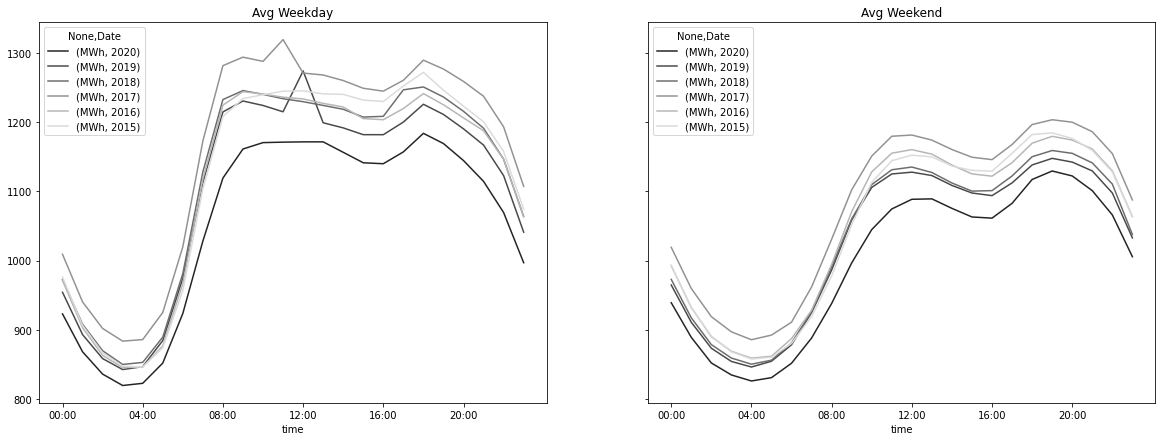

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

weekend = np.where(df.index.weekday < 5, 'Weekday', 'Weekend')
year_by_wkday_time = df.groupby([weekend, df.index.year, df.index.time]).mean()

year_by_wkday_time.loc['Weekday'].unstack(level=0).iloc[:, ::-1].plot(
    ax=ax[0], title='Avg Weekday', xticks=hourly_ticks)

year_by_wkday_time.loc['Weekend'].unstack(level=0).iloc[:, ::-1].plot(
    ax=ax[1], title='Avg Weekend', xticks=hourly_ticks)

plt.show()
fig.savefig('avg_by_year.png')

In [6]:
yeardate_mwh = df.groupby([df.index.year, df.index.date]).sum()
per_year_min = yeardate_mwh.min(level=0)

min_mwh_dates_per_year = []
for year in per_year_min.index:
  one_year_mwh = yeardate_mwh.loc[year]
  min_mwh_date = one_year_mwh[one_year_mwh['MWh'] == per_year_min.loc[year]['MWh']].index[0]
  min_mwh_dates_per_year.append(min_mwh_date)

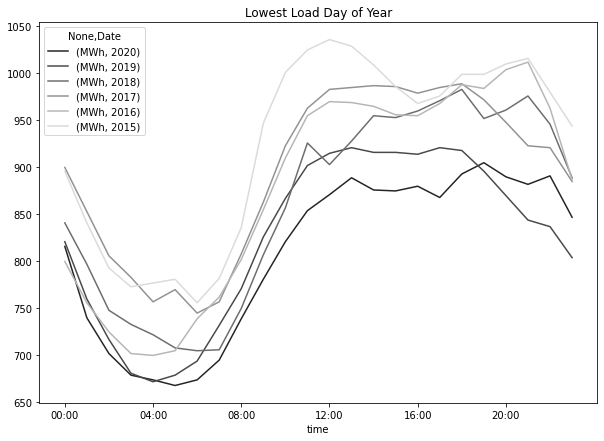

In [7]:
minmwhday = df[np.isin(df.index.date, min_mwh_dates_per_year)]
per_year_minmwhday = minmwhday.groupby([minmwhday.index.year, minmwhday.index.time]).mean()
ax = per_year_minmwhday.unstack(level=0).iloc[:, ::-1].plot(
    title='Lowest Load Day of Year', xticks=hourly_ticks, figsize=(10, 7))

plt.show()
ax.get_figure().savefig('lowest_by_year.png')